In [2]:
import pandas as pd


def remove_hex_bounces_until_stable(hex_transitions_df, min_time_in_hex=0.3):
    """
    Given a df of hex transitions, remove "bounces" between hexes such that
    if the rat leaves a hex for < min_time_in_hex seconds and returns to the same hex,
    merge the three hex transitions into a single hex entry.

    Parameters:
        hex_transitions_df (pd.DataFrame): df with 'hex', 'entry_time', 'exit_time', 'time_in_hex'
        min_time_in_hex (float): Minimum time (in seconds) for the rat to be in an intermediate hex
            for the transition to be valid
    """

    def remove_hex_bounces_once(hex_transitions_df, min_time_in_hex):
        """
        Given a df of hex transitions, if the rat leaves a hex for < min_time_in_hex seconds
        and returns to the same hex, merge the three hex transitions into a single hex entry.

        Parameters:
            hex_transitions_df (pd.DataFrame): df with 'hex', 'entry_time', 'exit_time', 'time_in_hex'
            min_time_in_hex (float): Minimum time (in seconds) for the rat to be in an intermediate hex
                for the transition to be valid

        Returns:
            pd.DataFrame: Updated df with bounce transitions removed
            bool: Whether any bounces were removed in this pass
        """
        merged = []
        i = 0
        changed = False

        # Loop through each hex entry row
        while i < len(hex_transitions_df) - 2:
            prev_row = hex_transitions_df.iloc[i]
            middle_row = hex_transitions_df.iloc[i + 1]
            next_row = hex_transitions_df.iloc[i + 2]

            # If we go from a hex to a different hex and back again too quickly,
            # remove the time in the intermediate hex
            if (prev_row["hex"] == next_row["hex"]) and (
                middle_row["time_in_hex"] < min_time_in_hex
            ):
                merged.append(
                    {
                        "hex": prev_row["hex"],
                        "entry_time": prev_row["entry_time"],
                        "exit_time": next_row["exit_time"],
                        "time_in_hex": next_row["exit_time"] - prev_row["entry_time"],
                    }
                )
                i += 3  # skip an extra 2 rows because we combined these into a single hex entry
                changed = True
            # If this didn't happen, add the row like normal
            else:
                merged.append(prev_row.to_dict())
                i += 1

        # Handle the remaining unprocessed rows
        while i < len(hex_transitions_df):
            merged.append(hex_transitions_df.iloc[i].to_dict())
            i += 1

        # Return the debounced df and if the original df was changed
        return pd.DataFrame(merged), changed

    # Iteratively remove bounces until no more changes are made
    current_df = hex_transitions_df.copy()
    while True:
        # Remove "bounces" between hex transitions
        current_df, changed = remove_hex_bounces_once(current_df, min_time_in_hex)
        if not changed:
            break
    return current_df

In [ ]:
import spyglass.common as sgc
import spyglass.data_import as sgi
from spyglass.common import Session, Nwbfile, LabTeam, IntervalList
from spyglass_hexmaze.hex_maze_behavior import HexPosition, HexMazeBlock, HexMazeBlock
import pandas as pd

key = {"nwb_file_name": "IM-1478_20220719_.nwb"}

# Block table
display((HexMazeBlock & key))

# Trial table
display((HexMazeBlock.Trial & key))

# Entries in hex position table
display((HexPosition & key))

# Position assigned to hex
hex_position_df = (HexPosition & key).fetch1_dataframe()
display(hex_position_df)

# Identify hex changes
hex_change_indices = hex_position_df["hex"] != hex_position_df["hex"].shift()
transition_points = hex_position_df[hex_change_indices].copy()

# Get hex entry and exit times
entry_time = transition_points.index.to_series()
exit_time = entry_time.shift(-1)
exit_time.iloc[-1] = (
    hex_position_df.index.max()
)  # last exit time is the last time of the df

hex_transitions_df = pd.DataFrame(
    {
        "hex": transition_points["hex"].values,
        "entry_time": entry_time.values,
        "exit_time": exit_time.values,
    }
)
hex_transitions_df["time_in_hex"] = (
    hex_transitions_df["exit_time"] - hex_transitions_df["entry_time"]
)

print("Hex transition df:")
display(hex_transitions_df)

print("Hex transition df (debounced):")
cleaned_transitions_df = remove_hex_bounces_until_stable(
    hex_transitions_df, min_time_in_hex=0.5
)
display(cleaned_transitions_df)


# # Fetch trials for the nwbfile
# trials = (HexMazeBlock.Trial & key).fetch(order_by='epoch_trial_num', as_dict=True)
# for trial in trials:
#     trial_interval = (IntervalList & {"interval_list_name" : trial["interval_list_name"]})

[2025-05-19 18:16:43,191][INFO]: DataJoint 0.14.4 connected to scrater@lmf-db.cin.ucsf.edu:3306


nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),block the block number within the epoch,config_id maze configuration as a string,interval_list_name descriptive name of this interval list,p_a probability of reward at port A,p_b probability of reward at port B,p_c probability of reward at port C,num_trials number of trials in this block,task_type 'barrier shift' or 'probabilty shift'
IM-1478_20220719_.nwb,0,1,"8,9,16,18,23,27,35,42,44",epoch0_block1,90.0,10.0,50.0,65,barrier change
IM-1478_20220719_.nwb,0,2,"8,9,18,21,23,27,35,42,44",epoch0_block2,90.0,10.0,50.0,62,barrier change
IM-1478_20220719_.nwb,0,3,"8,9,18,21,23,24,27,42,44",epoch0_block3,90.0,10.0,50.0,58,barrier change


nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),block the block number within the epoch,block_trial_num trial number within the block,interval_list_name descriptive name of this interval list,epoch_trial_num trial number within the epoch,reward if the rat got a reward,"start_port A, B, or C","end_port A, B, or C","opto_cond description of opto condition, if any (delay / no_delay)","poke_interval np.array of [poke_in, poke_out]",duration trial duration in seconds
IM-1478_20220719_.nwb,0,1,1,epoch0_block1_trial1,1,0,None,C,None,=BLOB=,37.2445
IM-1478_20220719_.nwb,0,1,2,epoch0_block1_trial2,2,1,C,B,None,=BLOB=,31.1152
IM-1478_20220719_.nwb,0,1,3,epoch0_block1_trial3,3,1,B,C,None,=BLOB=,21.6368
IM-1478_20220719_.nwb,0,1,4,epoch0_block1_trial4,4,1,C,A,None,=BLOB=,54.662
IM-1478_20220719_.nwb,0,1,5,epoch0_block1_trial5,5,0,A,B,None,=BLOB=,9.01763
IM-1478_20220719_.nwb,0,1,6,epoch0_block1_trial6,6,0,B,C,None,=BLOB=,17.0026
IM-1478_20220719_.nwb,0,1,7,epoch0_block1_trial7,7,1,C,A,None,=BLOB=,81.1043
IM-1478_20220719_.nwb,0,1,8,epoch0_block1_trial8,8,0,A,B,None,=BLOB=,22.7089
IM-1478_20220719_.nwb,0,1,9,epoch0_block1_trial9,9,1,B,C,None,=BLOB=,32.461
IM-1478_20220719_.nwb,0,1,10,epoch0_block1_trial10,10,1,C,A,None,=BLOB=,18.5386


pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_assignment_object_id
b85b6071-790f-9f36-b82d-8f6ef703fb0e,IM-1478_20220719_.nwb,0,IM-1478_20220719_1Z6V7Y8AAC.nwb,a0b2a489-cd95-4ae2-b12d-856cc3e7e62e


,hex,hex_including_sides,distance_from_centroid
time,,,
0.712208,11,11,63.363799
0.733519,11,11,63.554927
0.782489,11,11,63.323982
0.847202,11,11,63.246695
0.910277,11,11,62.750289
...,...,...,...
7141.946028,-1,None,-1.000000
7142.010011,-1,None,-1.000000
7142.073610,-1,None,-1.000000


Hex transition df:


,hex,entry_time,exit_time,time_in_hex
0,11,0.712208,4.717529,4.005322
1,22,4.717529,5.581561,0.864032
2,38,5.581561,6.045383,0.463822
3,22,6.045383,7.037780,0.992396
4,26,7.037780,7.117456,0.079676
...,...,...,...,...
4089,7,7057.901780,7058.157801,0.256021
4090,5,7058.157801,7058.493890,0.336089
4091,4,7058.493890,7058.701808,0.207918
4092,1,7058.701808,7070.826788,12.124980


Hex transition df (debounced):


,hex,entry_time,exit_time,time_in_hex
0,11.0,0.712208,4.717529,4.005322
1,22.0,4.717529,7.037780,2.320251
2,26.0,7.037780,7.117456,0.079676
3,21.0,7.117456,7.183795,0.066339
4,14.0,7.183795,7.839837,0.656043
...,...,...,...,...
3429,7.0,7057.901780,7058.157801,0.256021
3430,5.0,7058.157801,7058.493890,0.336089
3431,4.0,7058.493890,7058.701808,0.207918
3432,1.0,7058.701808,7070.826788,12.124980


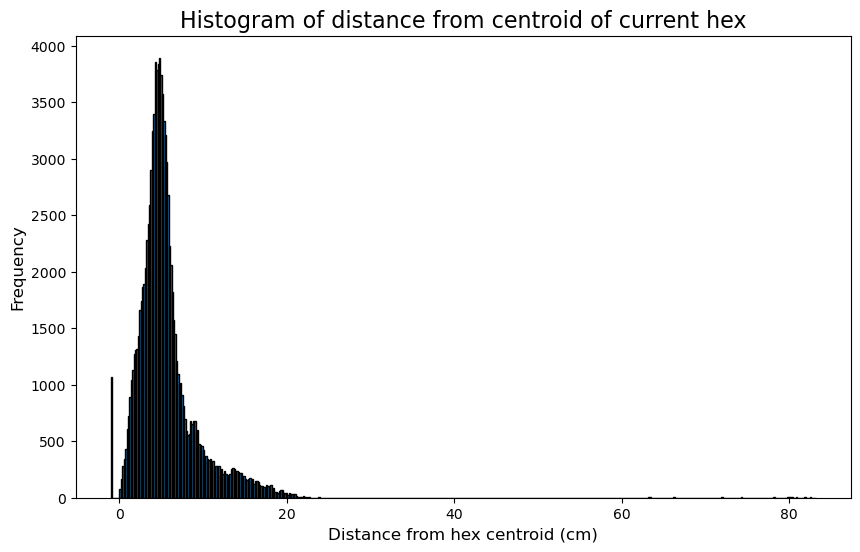

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(hex_position_df["distance_from_centroid"], bins=500, edgecolor="black")
plt.title("Histogram of distance from centroid of current hex", fontsize=16)
plt.xlabel("Distance from hex centroid (cm)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

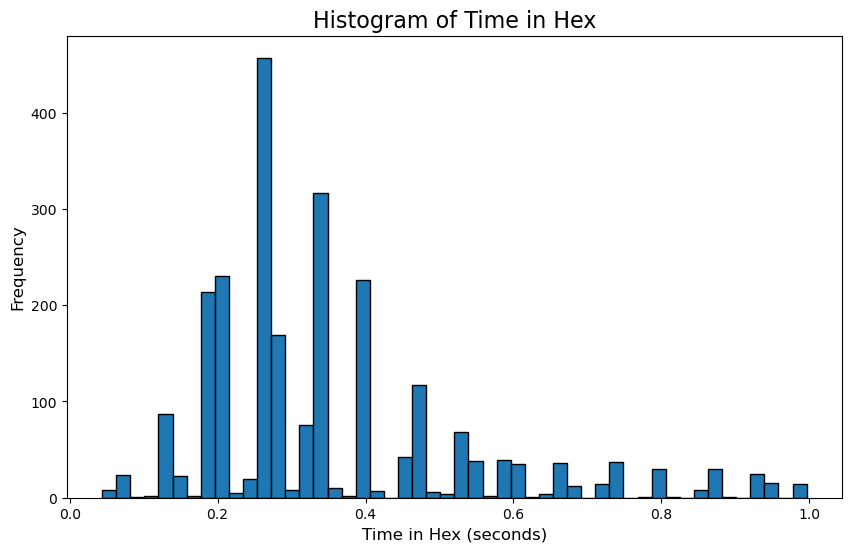

18.562162162162164


In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    cleaned_transitions_df[cleaned_transitions_df["time_in_hex"] < 1]["time_in_hex"],
    bins=50,
    edgecolor="black",
)
plt.title("Histogram of Time in Hex", fontsize=16)
plt.xlabel("Time in Hex (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

print(3434 / 185)

In [ ]:
import spyglass

print(spyglass.__file__)


# key = {"nwb_file_name": "IM-1478_20220719_.nwb"}

# (Nwbfile & key).delete()

# sgi.insert_sessions("IM-1478_20220719.nwb")

/home/scrater/dev/spyglass/src/spyglass/__init__.py


In [8]:
from spyglass.common import common_usage

(
    common_usage.InsertError()
    & {"dj_user": "scrater", "nwb_file_name": "IM-1478_20220719_.nwb"}
)  # .fetch("error_raw")

id,dj_user,connection_id MySQL CONNECTION_ID(),nwb_file_name,table,error_type,error_message,error_raw
152,scrater,89841,IM-1478_20220719_.nwb,Session,DataError,"(1406, ""Data too long for column 'probe_id' at row 1"")",=BLOB=
153,scrater,89872,IM-1478_20220719_.nwb,Session,DataError,"(1406, ""Data too long for column 'probe_id' at row 1"")",=BLOB=
154,scrater,89874,IM-1478_20220719_.nwb,Session,DataError,"(1406, ""Data too long for column 'probe_id' at row 1"")",=BLOB=
155,scrater,89899,IM-1478_20220719_.nwb,ElectrodeGroup,DataError,"(1406, ""Data too long for column 'probe_id' at row 1"")",=BLOB=
156,scrater,89899,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
157,scrater,9,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
158,scrater,104,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
159,scrater,106,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
160,scrater,130,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
161,scrater,132,IM-1478_20220719_.nwb,StateScriptFile,TypeError,argument of type 'builtin_function_or_method' is not iterable,=BLOB=
